In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


In [2]:
def compute_trend(series):
    """Compute linear trend (slope) across a time series."""
    if len(series) < 2:
        return 0
    return linregress(range(len(series)), series).slope

def aggregate_subject_level(df):
    """Aggregate features per subject (mean, std, trend, etc)."""
    def per_subject(group):
        return pd.Series({
            'mean_sleep_eff': group['sleep_efficiency'].mean(),
            'std_sleep_eff': group['sleep_efficiency'].std(),
            'bad_sleep_days': (group['sleep_efficiency'] < 85).sum(),
            'eff_trend': compute_trend(group['sleep_efficiency']),
            'mean_deep_pct': group['deep_sleep_pct'].mean(),
            'std_deep_pct': group['deep_sleep_pct'].std(),
            'deep_trend': compute_trend(group['deep_sleep_pct']),
            'mean_rem_pct': group['rem_sleep_pct'].mean(),
            'std_rem_pct': group['rem_sleep_pct'].std(),
            'mean_hr_wake_deep_diff': group['hr_wake_deep_diff'].mean(),
            'std_hr_wake_deep_diff': group['hr_wake_deep_diff'].std(),
            'depression_present': group['depression_present'].iloc[0]
        })
    return df.groupby('src_subject_id').apply(per_subject).reset_index()


In [3]:
def split_data(df, target_col='depression_present', test_size=0.3):
    """Split into train and test sets with stratification."""
    X = df.drop(columns=["src_subject_id", target_col])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

def train_rf_model(X_train, y_train):
    """Train a Random Forest with class_weight=balanced."""
    model = RandomForestClassifier(class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    return model

def train_logistic(X_train, y_train):
    model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    model = XGBClassifier(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)
    model.fit(X_train, y_train)
    return model


In [4]:
def evaluate_model(model, X_test, y_test):
    """Print classification report and return prediction probs."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))

    return y_pred, y_proba

def plot_roc(y_test, y_proba):
    """Plot ROC curve."""
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X):
    """Plot top 15 features based on importance."""
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feat_df = feat_df.sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feat_df)
    plt.title("Top 15 Feature Importances")
    plt.tight_layout()
    plt.show()


In [5]:
def split_and_smote(df, target_col='depression_present', test_size=0.3):
    """Split and apply SMOTE on training set."""
    X = df.drop(columns=["src_subject_id", target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    sm = SMOTE(random_state=42)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    return X_train_smote, X_test, y_train_smote, y_test

def upsample_minority(df, target_col='depression_present'):
    """Randomly upsample the minority class."""
    df_majority = df[df[target_col] == 0]
    df_minority = df[df[target_col] == 1]

    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )

    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled


In [6]:
df = pd.read_csv("../data/clean_data/sleep_depression_final_dataset.csv")

/var/folders/5_/qxz93g8n1rj5366g0fsr39kr0000gn/T/ipykernel_74405/1058243744.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('src_subject_id').apply(per_subject).reset_index()


Classification Report:

              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       714
         1.0       0.50      0.02      0.03       236

    accuracy                           0.75       950
   macro avg       0.63      0.51      0.45       950
weighted avg       0.69      0.75      0.65       950



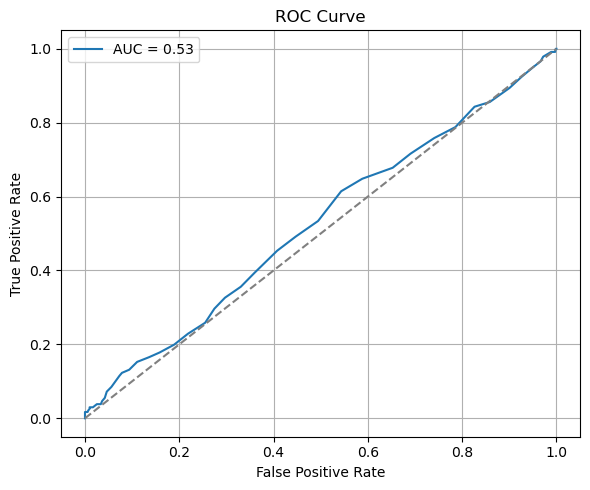

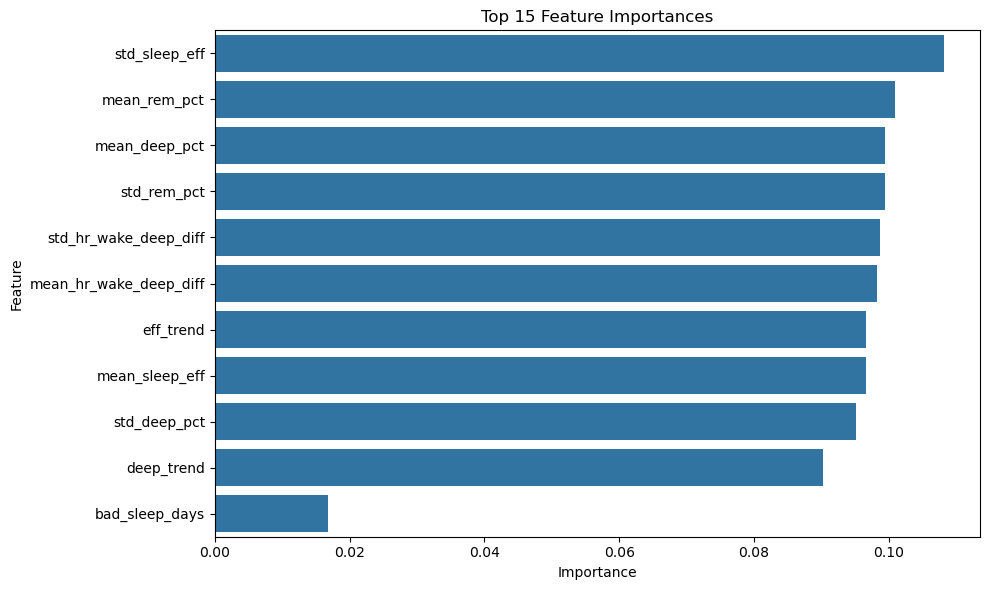

In [7]:
# 1. Load your raw dataset (already cleaned daily-level data)
# Example: df_raw = pd.read_csv("your_data.csv")

# 2. Aggregate to subject-level
df_model = aggregate_subject_level(df)

# 3. Split data
X_train, X_test, y_train, y_test = split_data(df_model)

# 4. Train model
model = train_rf_model(X_train, y_train)

# 5. Evaluate model
y_pred, y_proba = evaluate_model(model, X_test, y_test)

# 6. Plot ROC curve and Feature Importances
plot_roc(y_test, y_proba)
plot_feature_importance(model, X_train)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81       714
         1.0       0.29      0.16      0.21       236

    accuracy                           0.69       950
   macro avg       0.53      0.52      0.51       950
weighted avg       0.64      0.69      0.66       950



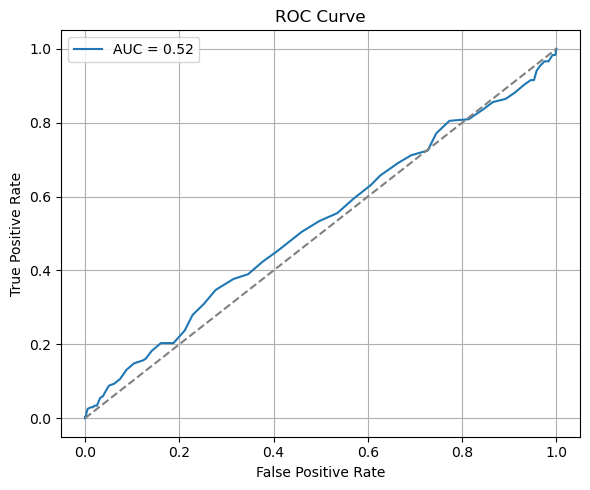

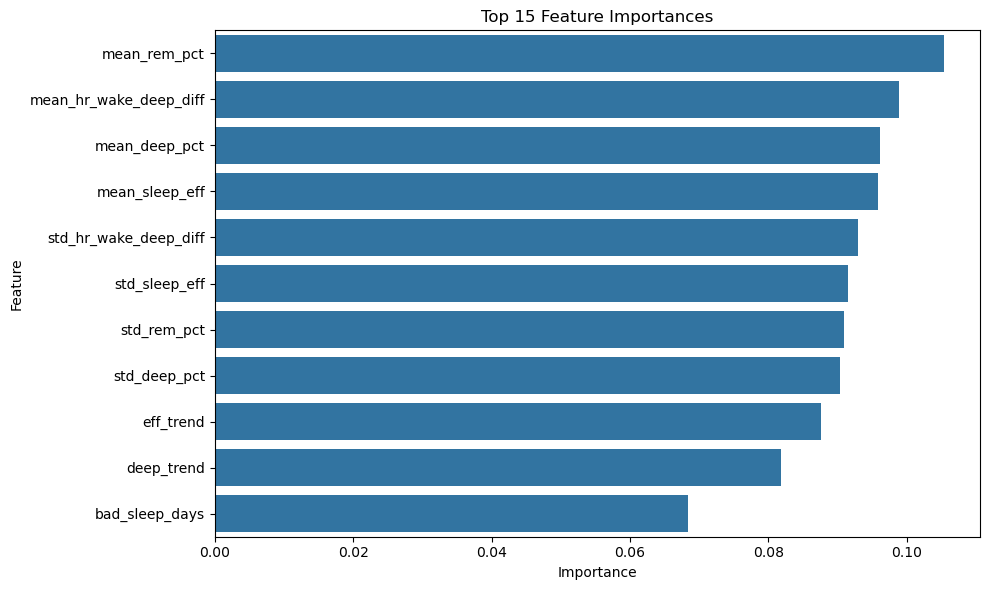

In [8]:
X_train, X_test, y_train, y_test = split_and_smote(df_model)
smote_model = train_rf_model(X_train, y_train)
y_pred, y_proba = evaluate_model(smote_model, X_test, y_test)
plot_roc(y_test, y_proba)
plot_feature_importance(smote_model, X_train)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       714
         1.0       0.91      0.90      0.90       713

    accuracy                           0.91      1427
   macro avg       0.91      0.91      0.91      1427
weighted avg       0.91      0.91      0.91      1427



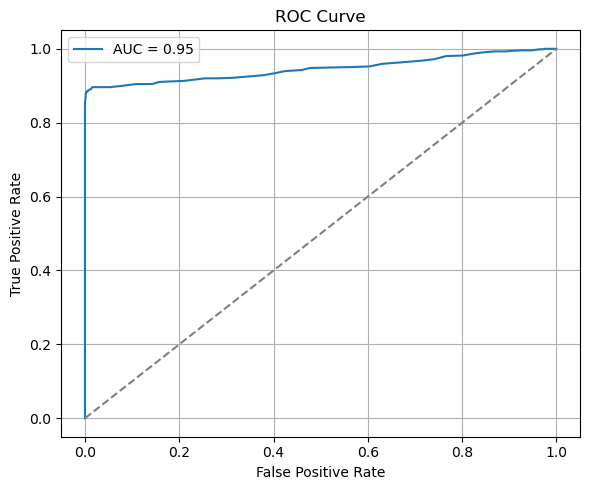

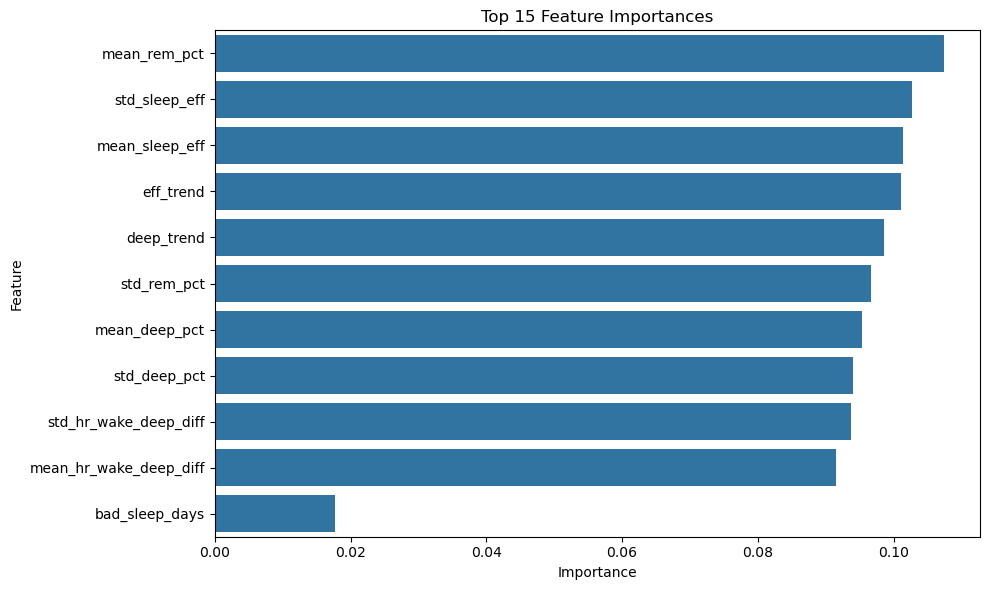

In [9]:
df_upsampled = upsample_minority(df_model)
X_train, X_test, y_train, y_test = split_data(df_upsampled)
upsampled_model = train_rf_model(X_train, y_train)
y_pred, y_proba = evaluate_model(upsampled_model, X_test, y_test)
plot_roc(y_test, y_proba)
plot_feature_importance(upsampled_model, X_train)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.55      0.56      0.56       714
         1.0       0.55      0.54      0.55       713

    accuracy                           0.55      1427
   macro avg       0.55      0.55      0.55      1427
weighted avg       0.55      0.55      0.55      1427



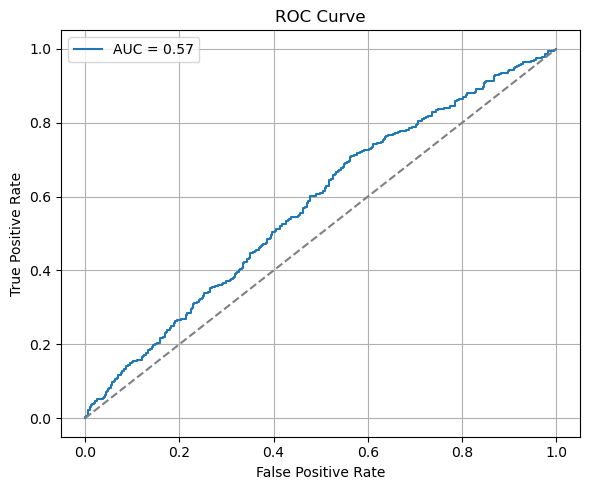

/opt/homebrew/Caskroom/miniforge/base/envs/diss/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:

              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86       714
         1.0       0.83      0.92      0.87       713

    accuracy                           0.87      1427
   macro avg       0.87      0.87      0.87      1427
weighted avg       0.87      0.87      0.87      1427



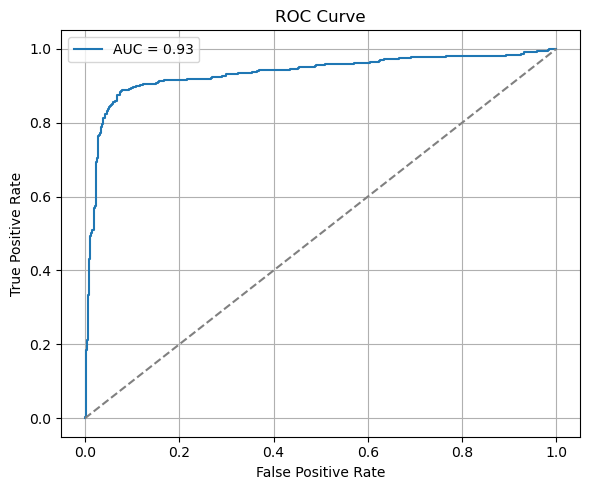

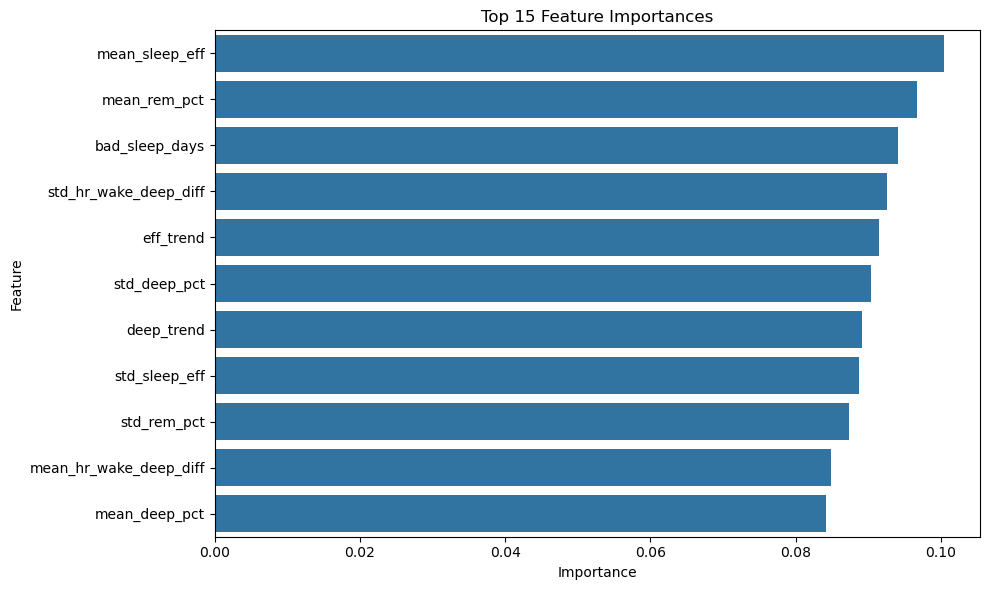

In [10]:
logistic_model = train_logistic(X_train, y_train)
y_pred, y_proba = evaluate_model(logistic_model, X_test, y_test)
plot_roc(y_test, y_proba)

xgboost_model = train_xgboost(X_train, y_train)
y_pred, y_proba = evaluate_model(xgboost_model, X_test, y_test)
plot_roc(y_test, y_proba)
plot_feature_importance(xgboost_model, X_train)
